[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2022-01-03    1214.458618
2022-01-04    1209.894409
2022-01-05    1265.201050
2022-01-06    1346.886597
2022-01-07    1305.200073
                 ...     
2022-03-25    1710.088379
2022-03-28    1746.058716
2022-03-29    1783.999023
2022-03-30    1796.006348
2022-03-31    1797.178589
Freq: B, Name: Weighted_Price_Prediction, Length: 64, dtype: float32


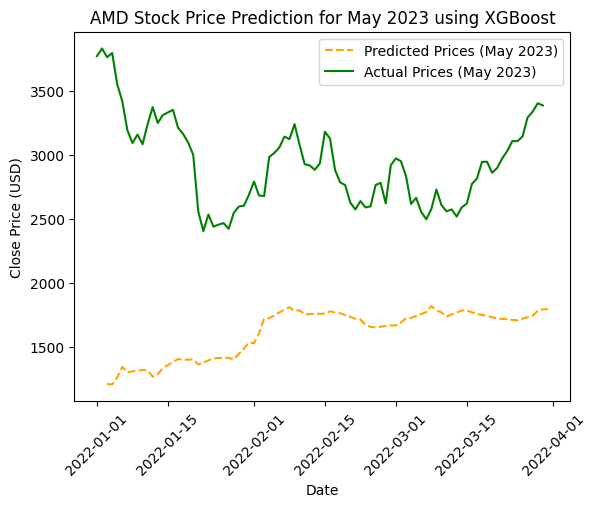

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# Function to create a variety of time-based features from a time series DataFrame
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


# Download AMD stock data for training (up to end of April 2023)
df_train = yf.download('ETH-USD', start='2019-01-01', end='2021-12-31')
df_train['Weighted_Price'] = df_train['Close']

# Create training features and labels
X_train, y_train = create_features(df_train, label='Weighted_Price')

# Initialize the XGBoost model with specified parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    min_child_weight=10,
    booster='gbtree',
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=100
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

# Generate dates for May 2023 (without downloading the actual data yet)
may_dates = pd.date_range(start='2022-01-01', end='2022-03-31', freq='B')  # Business days in May
df_may = pd.DataFrame(index=may_dates)

# Create features for the synthetic May 2023 dates
X_may = create_features(df_may)
# Make predictions for May 2023
df_may['Weighted_Price_Prediction'] = model.predict(X_may)
print(df_may['Weighted_Price_Prediction'])
# Download actual AMD stock data for May 2023 after prediction for comparison
df_actual_may = yf.download('ETH-USD', start='2022-01-01', end='2022-03-31')

plt.plot(df_may.index,df_may['Weighted_Price_Prediction'], color='orange', linestyle='dashed',
         label='Predicted Prices (May 2023)')

# Plot actual May 2023 prices
plt.plot(df_actual_may['Close'], color='green', label='Actual Prices (May 2023)')

# Customize the plot
plt.title('AMD Stock Price Prediction for May 2023 using XGBoost')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

